In [1]:
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import numpy as np
import pandas as pd
import time

import progressbar

In [2]:
train = pd.read_csv('./preprocessed/train.csv')
test = pd.read_csv('./preprocessed/test.csv')
test_labels = pd.read_csv('./dataset/test_labels.csv')

print(train.shape)
print(test.shape)
print(test_labels.shape)

(159571, 10)
(153164, 4)
(153164, 7)


In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_lemma,comment_stem
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,Explanation Why the edits make under my userna...,explan whi the edit made under my usernam hard...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,D'aww ! He match this background colour I 'm s...,d'aww ! He match thi background colour I 'm se...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"Hey man , I 'm really not try to edit war . It...","hey man , I 'm realli not tri to edit war . It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,`` More I ca n't make any real suggestion on i...,`` more I ca n't make ani real suggest on impr...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"You , sir , be my hero . Any chance you rememb...","you , sir , are my hero . ani chanc you rememb..."


In [4]:
test.head()

,id,comment_text,comment_lemma,comment_stem
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,Yo bitch Ja Rule be more succesful then you 'l...,Yo bitch Ja rule is more succes then you 'll e...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"== From RfC == The title be fine as it be , IMO .","== from rfc == the titl is fine as it is , imo ."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",`` == Sources == * Zawe Ashton on Lapland — / ``,`` == sourc == * zaw ashton on lapland — / ``
3,00017563c3f7919a,":If you have a look back at the source, the in...",": If you have a look back at the source , the ...",": If you have a look back at the sourc , the i..."
4,00017695ad8997eb,I don't anonymously edit articles at all.,I do n't anonymously edit article at all .,I do n't anonym edit articl at all .


In [5]:
token_regex = r'[a-zA-Z0-9]+'
tokenizer = RegexpTokenizer(token_regex).tokenize

In [34]:
def training(X, classifier, **kwargs):
    test_cols = [ 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    roc_aoc_scores = []
    clfs = []
    
    for eval_col in test_cols:
#         print("FIT ", eval_col)
        y = train[eval_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=101)

        clf = classifier(**kwargs).fit(X_train, y_train)
        predicted= clf.predict_proba(X_test)[:,1]
            
        roc_aoc_scores.append(metrics.roc_auc_score(y_test, predicted))
        clfs.append(clf)
    
    avg_score = np.mean(np.array(roc_aoc_scores))
    for index, score in enumerate(roc_aoc_scores) :
        print("Score for {:<10} is {:<10}".format(test_cols[index], score))
    print("Score :" , avg_score)
    return clfs, roc_aoc_scores

In [26]:
def clf(**kwargs):
    return LogisticRegression(C=2, solver='lbfgs', **kwargs)

In [7]:
vectorizer = {
    'cv' : CountVectorizer(lowercase=False, stop_words='english', ngram_range = (1,1), tokenizer = tokenizer),
    'cv_max' : CountVectorizer(lowercase=False, stop_words='english', ngram_range = (1,2), tokenizer = tokenizer, max_features=80000),
    
    'tf' : TfidfVectorizer(lowercase=True, strip_accents='unicode', ngram_range = (1,1), tokenizer = tokenizer),
    'tf_max' : TfidfVectorizer(lowercase=True, strip_accents='unicode', ngram_range = (1,2), tokenizer = tokenizer, max_features=100000)
}

In [17]:
text_vec = {}
input_cols = ['comment_text', 'comment_stem', 'comment_lemma']

for v in vectorizer:
    for col in input_cols:
        vv = vectorizer[v]
        key = v + '_' + col.split('_')[-1]
        print(key)
        
        text_vec[key] = vv.fit_transform(train[col])
        num_features = len(vv.get_feature_names())
        print("Num Features : ", num_features)

cv_text
Num Features :  227490
cv_stem
Num Features :  154983
cv_lemma
Num Features :  218494
cv_max_text
Num Features :  80000
cv_max_stem
Num Features :  80000
cv_max_lemma
Num Features :  80000
tf_text
Num Features :  182596
tf_stem
Num Features :  154706
tf_lemma
Num Features :  175930
tf_max_text
Num Features :  100000
tf_max_stem
Num Features :  100000
tf_max_lemma
Num Features :  100000


In [18]:
import pickle

In [22]:
# with open('./pickles/text_vec.pickle', 'wb') as file:
#     pickle.dump(text_vec, file)

In [30]:
# with open('./pickles/text_vec.pickle', 'rb') as file:
#     tt = pickle.load(file)

In [42]:
with open('./pickles/result_lr.pickle', 'rb') as file:
    lr_data = pickle.load(file)

In [43]:
for key in text_vec:
    print("Input : {}".format(key))

    if key in lr_data:
        print("Found in Saved Data")
        continue
    
    if 'cv' in key:
        trained_clfs, scores = training(text_vec[key], clf, max_iter=1600)
    else :
        trained_clfs, scores = training(text_vec[key], clf, max_iter=600)
    
    lr_data[key] = {
        "scores" : scores,
        "avg" :  np.mean(np.array(scores))
    }

Input : cv_text
Score for toxic      is 0.9500555360895766
Score for severe_toxic is 0.9444719090720722
Score for obscene    is 0.9629161293031663
Score for threat     is 0.9347181507626681
Score for insult     is 0.94796140087133
Score for identity_hate is 0.9101338066602189
Score : 0.9417094887931721
Input : cv_stem
Score for toxic      is 0.950536267786916
Score for severe_toxic is 0.9426663435544977
Score for obscene    is 0.9641733866478888
Score for threat     is 0.933195038619079
Score for insult     is 0.939385837725499
Score for identity_hate is 0.8887015902837803
Score : 0.9364430774362767
Input : cv_lemma
Score for toxic      is 0.9507237710777398
Score for severe_toxic is 0.9457961849121027
Score for obscene    is 0.960852260655784
Score for threat     is 0.9402112981000272
Score for insult     is 0.9486444422065557
Score for identity_hate is 0.9092995577463254
Score : 0.9425879191164225
Input : cv_max_text
Score for toxic      is 0.9479295668271273
Score for severe_toxic i

C:\Users\dhruv\.conda\envs\nlp\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\dhruv\.conda\envs\nlp\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\dhruv\.conda\envs\nlp\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Score for toxic      is 0.9506431062472793
Score for severe_toxic is 0.9516374698252252
Score for obscene    is 0.9688943722179185
Score for threat     is 0.9433204049226289
Score for insult     is 0.9502250283615298
Score for identity_hate is 0.9446765885108601
Score : 0.9515661616809069
Input : cv_max_lemma
Score for toxic      is 0.9494371107377796
Score for severe_toxic is 0.9457801734002663
Score for obscene    is 0.9600277200833518
Score for threat     is 0.9463865675746974
Score for insult     is 0.9480104087788045
Score for identity_hate is 0.9376301040832666
Score : 0.947878680776361
Input : tf_text
Score for toxic      is 0.9725291154300559
Score for severe_toxic is 0.982298276880128
Score for obscene    is 0.9843297967773662
Score for threat     is 0.9850980532998505
Score for insult     is 0.9771971677602339
Score for identity_hate is 0.9746343673141336
Score : 0.9793477962436281
Input : tf_stem
Score for toxic      is 0.9742971418732155
Score for severe_toxic is 0.98345435

In [44]:
lr_data

{'cv_text': {'scores': [0.9500555360895766,
   0.9444719090720722,
   0.9629161293031663,
   0.9347181507626681,
   0.94796140087133,
   0.9101338066602189],
  'avg': 0.9417094887931721},
 'cv_stem': {'scores': [0.950536267786916,
   0.9426663435544977,
   0.9641733866478888,
   0.933195038619079,
   0.939385837725499,
   0.8887015902837803],
  'avg': 0.9364430774362767},
 'cv_lemma': {'scores': [0.9507237710777398,
   0.9457961849121027,
   0.960852260655784,
   0.9402112981000272,
   0.9486444422065557,
   0.9092995577463254],
  'avg': 0.9425879191164225},
 'cv_max_text': {'scores': [0.9479295668271273,
   0.9437288112403079,
   0.9612667694205511,
   0.939947753815385,
   0.9488260774738515,
   0.9410902020717987],
  'avg': 0.9471315301415034},
 'cv_max_stem': {'scores': [0.9506431062472793,
   0.9516374698252252,
   0.9688943722179185,
   0.9433204049226289,
   0.9502250283615298,
   0.9446765885108601],
  'avg': 0.9515661616809069},
 'cv_max_lemma': {'scores': [0.9494371107377796,

In [45]:
with open('./pickles/result_lr.pickle', 'wb') as file:
    pickle.dump(lr_data, file)

In [262]:
with open('./pickles/result_lr.pickle', 'rb') as file:
    qwerty = pickle.load(file)

In [68]:
ppp = pd.DataFrame()
ppp['key'] = lr_data.keys()
ppp['avg'] = [lr_data[i]['avg'] for i in lr_data]

cols = [ 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for index,col in enumerate(cols):
    ppp[col] = [lr_data[i]["scores"][index] for i in lr_data]


In [69]:
ppp.head()

,key,avg,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,cv_text,0.941709,0.950056,0.944472,0.962916,0.934718,0.947961,0.910134
1,cv_stem,0.936443,0.950536,0.942666,0.964173,0.933195,0.939386,0.888702
2,cv_lemma,0.942588,0.950724,0.945796,0.960852,0.940211,0.948644,0.909300
3,cv_max_text,0.947132,0.947930,0.943729,0.961267,0.939948,0.948826,0.941090
4,cv_max_stem,0.951566,0.950643,0.951637,0.968894,0.943320,0.950225,0.944677


In [84]:
pppp = pd.melt(ppp, id_vars="key", var_name="type", value_name="roc score")
pppp.head()

,key,type,roc score
0,cv_text,avg,0.941709
1,cv_stem,avg,0.936443
2,cv_lemma,avg,0.942588
3,cv_max_text,avg,0.947132
4,cv_max_stem,avg,0.951566


In [255]:
pppp['color'] = '#ADCBE3'

In [256]:
for col in pppp['type'].unique():
    index = np.argmax(pppp[pppp['type'] == col]['roc score'])
    print(index)
    pppp.at[index, 'color'] = '#4B86B4'

10
22
34
43
58
70
82


In [257]:
sum(pppp['color'] == True)

0

In [258]:
import seaborn as sns
import matplotlib.pyplot as plt

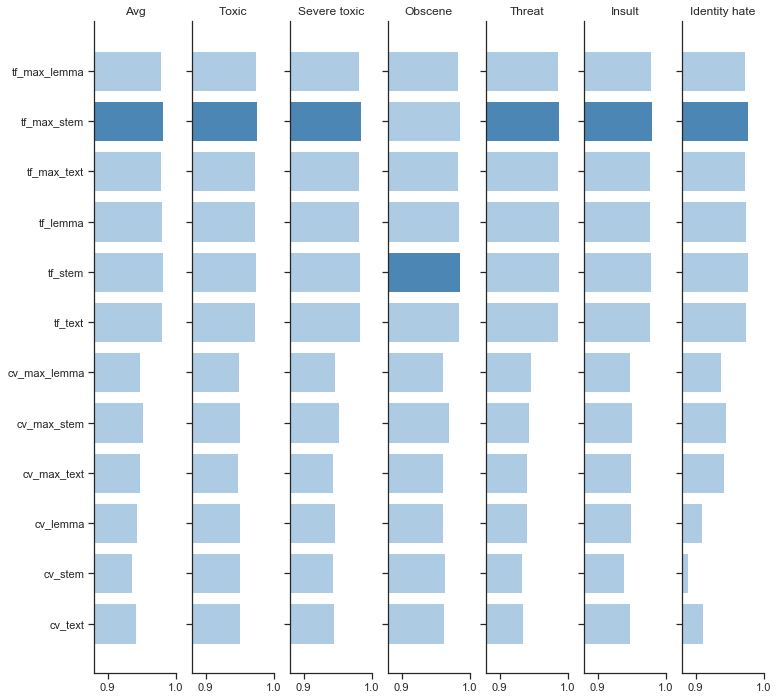

In [261]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(nrows=1, ncols=7, sharey="all", figsize=(12,12))
axs = axs.ravel()
index = 0


for index in range(7):
    axs[index].barh(ppp['key'], ppp[qqq[index]] ,color=pppp[pppp["type"] == qqq[index]]['color'])
    axs[index].set_xlim(0.88,1)
    axs[index].spines['right'].set_visible(False)
    axs[index].spines['top'].set_visible(False)
    axs[index].set_title(qqq[index].replace('_', ' ').capitalize())
#     plt.xlabel('Type of Model')
#     plt.ylabel('ROC AOC Score')

    
plt.show()
fig.savefig('results.png')


# a = sns.catplot(x='key', y='roc score', hue='type', data=pppp, kind='point', height=5, aspect=3)
# a.savefig('results.png')

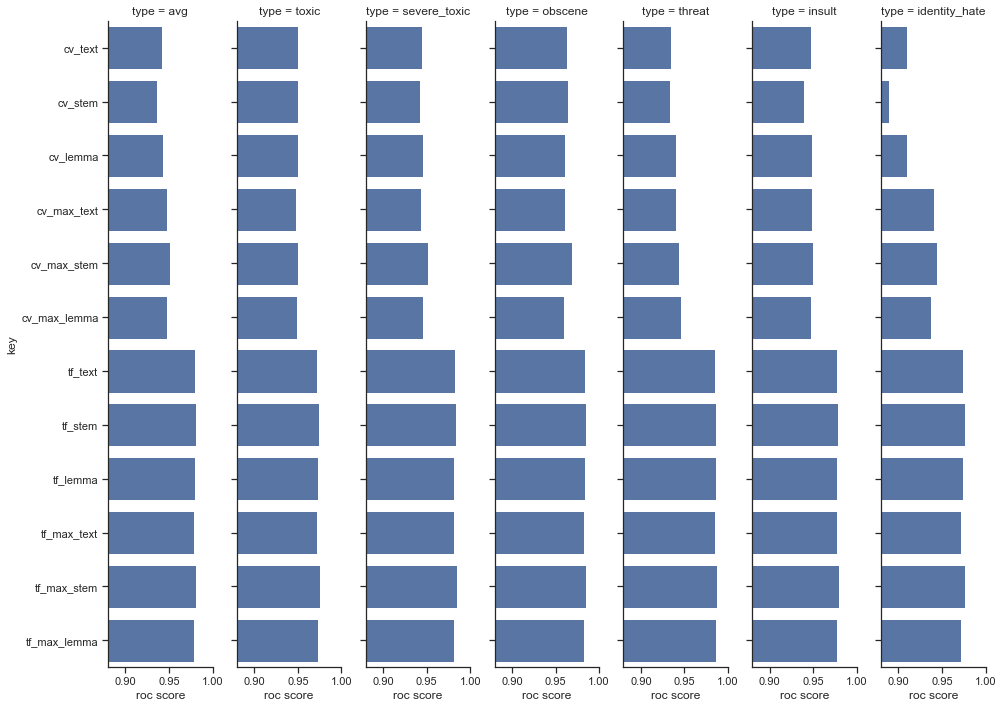

In [208]:
sns.set_color_codes("muted")
# sns.set_style("dark")
sns.set(style="ticks")
g = sns.catplot(y='key', x='roc score', data=pppp, col="type",kind='bar', height=10, aspect=1/5, color='b')
g.set(xlim=(0.88, 1))

In [106]:
qqq = ['avg']
qqq.extend(cols)

In [107]:
qqq

['avg',
 'toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']

In [195]:
ppp

,key,avg,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,cv_text,0.941709,0.950056,0.944472,0.962916,0.934718,0.947961,0.910134
1,cv_stem,0.936443,0.950536,0.942666,0.964173,0.933195,0.939386,0.888702
2,cv_lemma,0.942588,0.950724,0.945796,0.960852,0.940211,0.948644,0.909300
3,cv_max_text,0.947132,0.947930,0.943729,0.961267,0.939948,0.948826,0.941090
4,cv_max_stem,0.951566,0.950643,0.951637,0.968894,0.943320,0.950225,0.944677
5,cv_max_lemma,0.947879,0.949437,0.945780,0.960028,0.946387,0.948010,0.937630
6,tf_text,0.979348,0.972529,0.982298,0.984330,0.985098,0.977197,0.974634
7,tf_stem,0.980998,0.974297,0.983454,0.985556,0.986693,0.979016,0.976971
8,tf_lemma,0.979298,0.972697,0.981629,0.983590,0.986793,0.977102,0.973977
9,tf_max_text,0.978646,0.972590,0.981743,0.982793,0.985529,0.977319,0.971904


In [251]:
pppp[pppp["type"] == qqq[index]]['color']

0      blue
1      blue
2      blue
3      blue
4      blue
5      blue
6      blue
7      blue
8      blue
9      blue
10    black
11     blue
Name: color, dtype: object

In [263]:
qwerty

{'cv_text': {'scores': [0.9500555360895766,
   0.9444719090720722,
   0.9629161293031663,
   0.9347181507626681,
   0.94796140087133,
   0.9101338066602189],
  'avg': 0.9417094887931721},
 'cv_stem': {'scores': [0.950536267786916,
   0.9426663435544977,
   0.9641733866478888,
   0.933195038619079,
   0.939385837725499,
   0.8887015902837803],
  'avg': 0.9364430774362767},
 'cv_lemma': {'scores': [0.9507237710777398,
   0.9457961849121027,
   0.960852260655784,
   0.9402112981000272,
   0.9486444422065557,
   0.9092995577463254],
  'avg': 0.9425879191164225},
 'cv_max_text': {'scores': [0.9479295668271273,
   0.9437288112403079,
   0.9612667694205511,
   0.939947753815385,
   0.9488260774738515,
   0.9410902020717987],
  'avg': 0.9471315301415034},
 'cv_max_stem': {'scores': [0.9506431062472793,
   0.9516374698252252,
   0.9688943722179185,
   0.9433204049226289,
   0.9502250283615298,
   0.9446765885108601],
  'avg': 0.9515661616809069},
 'cv_max_lemma': {'scores': [0.9494371107377796,